In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np

In [3]:
train_losses = np.load('train_losses_v2_10_pst_March.npy')
test_losses = np.load('test_losses_v2_10_pst_March.npy')

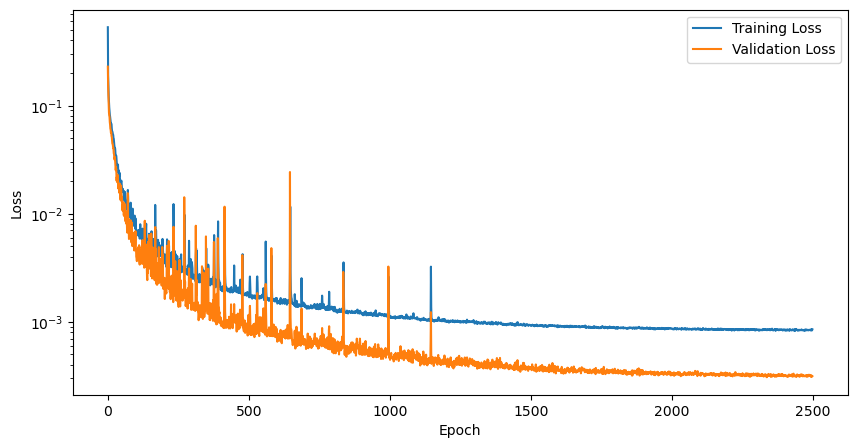

In [4]:
import matplotlib.pyplot as plt

# Plot the training and validation losses
plt.figure(figsize=(10,5))
plt.plot(train_losses, label='Training Loss')
plt.plot(test_losses, label='Validation Loss')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.yscale('log')
plt.show()

In [5]:
from train import *
import torch
predict_num = 10
train_dataset, test_dataset, n_features, n_inputs = data_preparation_v2(predict_num, 140)
params = Params(n_features, n_inputs)
model = build_model(params)
model = torch.load('model_v2_10_pst.pth')

['/home/shiqi/code/model_combination_Argos/gan_transformer', '/home/shiqi/anaconda3/envs/torch/lib/python39.zip', '/home/shiqi/anaconda3/envs/torch/lib/python3.9', '/home/shiqi/anaconda3/envs/torch/lib/python3.9/lib-dynload', '', '/home/shiqi/anaconda3/envs/torch/lib/python3.9/site-packages', '../utils']
../data_March/data_dict_1.npy
(142, 6957)
../data_March/data_dict_2.npy
(142, 6957)
../data_March/data_dict_3.npy
(142, 6957)
../data_March/data_dict_4.npy
(142, 6957)
../data_March/data_dict_5.npy
(142, 6957)
../data_March/data_dict_6.npy
(142, 6957)
../data_March/data_dict_7.npy
(142, 6957)
../data_March/data_dict_8.npy
(142, 6957)
../data_March/data_dict_9.npy
(142, 6957)
../data_March/data_dict_10.npy
(142, 6957)
../data_March/data_dict_11.npy
(142, 6957)
../data_March/data_dict_12.npy
(142, 6957)
../data_March/data_dict_13.npy
(142, 6957)
../data_March/data_dict_14.npy
(142, 6957)
../data_March/data_dict_15.npy
(142, 6957)
../data_March/data_dict_16.npy
(142, 6957)
../data_March/d

In [6]:
train_loader = DataLoader(train_dataset, batch_size=len(train_dataset), shuffle=False)

In [7]:
for batch in train_loader:
    x_train, y_train, u1_train, u2_train = batch

In [8]:
y_pred_scaled = model(x_train, u1_train, u2_train).detach().numpy()
y_pred = scaler_x.inverse_transform(y_pred_scaled.reshape(-1, n_features))

In [9]:
y_true = scaler_x.inverse_transform(y_train.detach().numpy().reshape(-1, n_features))

In [10]:
err = y_pred - y_true
err_norm = np.linalg.norm(err)
y_true_norm = np.linalg.norm(y_true)
ratio = err_norm / y_true_norm
print(ratio)


0.42252246


In [11]:
window_size = 140

# Data preparation
x_dataset = []
y_dataset = []
u1_dataset = []
u2_dataset = []

for suffix in range(1, 51):
    data_file_path = '../data_March/data_dict_' + str(suffix) + '.npy'
    
    # Check if the file exists before trying to load it
    if os.path.exists(data_file_path):
        data_dict = np.load(data_file_path, allow_pickle=True).item()
        x_data, y_data, u1_data, u2_data = load_dataset(data_dict, predict_num)
        x_dataset.append(x_data[:window_size])
        y_dataset.append(y_data[:window_size])
        u1_dataset.append(u1_data[:window_size])
        u2_dataset.append(u2_data[:window_size])
    else:
        print(f"File not found: {data_file_path}")

"""
x_data.shape = (n_samples, n_features)
y_data.shape = (n_samples, n_features)
u1_data.shape = (n_samples, n_inputs)
u2_data.shape = (n_samples, n_inputs)
"""


File not found: ../data_March/data_dict_26.npy
File not found: ../data_March/data_dict_28.npy


'\nx_data.shape = (n_samples, n_features)\ny_data.shape = (n_samples, n_features)\nu1_data.shape = (n_samples, n_inputs)\nu2_data.shape = (n_samples, n_inputs)\n'

In [12]:
len(x_dataset)

48

In [13]:
# start from the zero point
y_data_pred_50traj_10predict = []
for x_data, u1_data, u2_data in zip(x_dataset, u1_dataset, u2_dataset):
    steps = int(140 / predict_num)
    n_target = x_data.shape[1]
    x_data_scaled = scaler_x.transform(x_data)
    u1_data_scaled = scaler_u.transform(u1_data)
    u2_data_scaled = scaler_u.transform(u2_data)
    y_data_pred_scaled = [torch.tensor(x_data_scaled[0:predict_num,:], dtype = torch.float32)]
    for step in range(steps - 1):
        # print(step)
        x = torch.tensor(y_data_pred_scaled[-1].reshape((1, predict_num, -1)),dtype = torch.float32)
        u1 = torch.tensor(u1_data_scaled[predict_num * step: predict_num * (step + 1), :].reshape((1, predict_num, -1)), dtype = torch.float32)
        u2 = torch.tensor(u2_data_scaled[predict_num * step: predict_num * (step + 1), :].reshape((1, predict_num, -1)), dtype = torch.float32)
        y_pred = model(x, u1, u2)
        y_data_pred_scaled.append(y_pred.reshape(predict_num, -1))
    y_data_pred_scaled = torch.cat(y_data_pred_scaled, dim = 0).detach().numpy()
    # print(np.shape(y_data_pred_scaled))
    y_data_pred = scaler_x.inverse_transform(y_data_pred_scaled)
    y_data_pred_50traj_10predict.append(y_data_pred)


In [14]:
errors = [y_data_pred_50traj_10predict[i] - x_dataset[i][:(steps * predict_num), :] for i in range(len(y_data_pred_50traj_10predict))]

cumulative_error_norms = [np.array([np.linalg.norm(errors[i][:j+1,:]) for j in range(errors[i].shape[0])]) for i in range(len(errors))]

data_norms = [np.linalg.norm(x_dataset[i]) for i in range(len(x_dataset))]

relative_errors = [cumulative_error_norms[i] / data_norms[i] for i in range(len(cumulative_error_norms))] 

In [15]:
mean_relative_errors = np.mean(relative_errors, axis=0)
std_relative_errors = np.std(relative_errors, axis=0)   

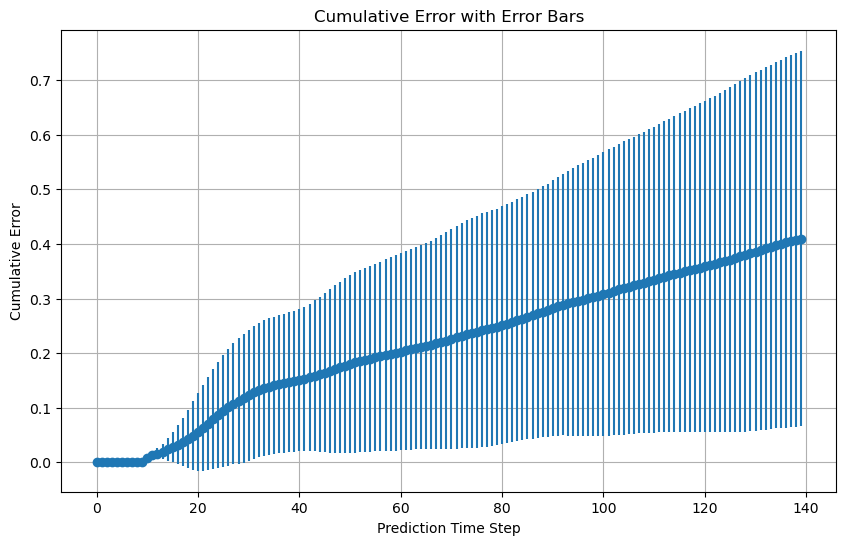

In [16]:
# Plot the relative error with error bars
plt.figure(figsize=(10, 6))
plt.errorbar(range(steps * predict_num), mean_relative_errors, yerr=std_relative_errors, fmt='-o')
plt.xlabel('Prediction Time Step')
plt.ylabel('Cumulative Error')
plt.title('Cumulative Error with Error Bars')
plt.grid(True)
plt.show()

In [17]:
domain_error_norms = [np.linalg.norm(errors[i]) for i in range(len(x_dataset))]
domain_relative_error = [domain_error_norms[i]/data_norms[i] for i in range(len(domain_error_norms))]

In [18]:
np.mean(domain_relative_error)

0.4098237611036774

In [19]:
np.std(domain_relative_error)

0.34388689150032115

In [20]:
x_dataset[0].shape

(140, 6957)

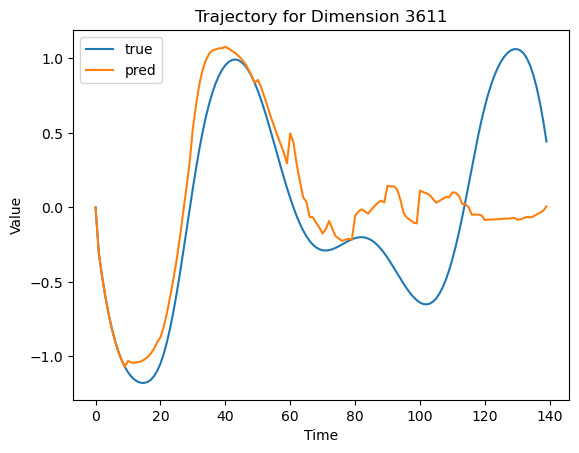

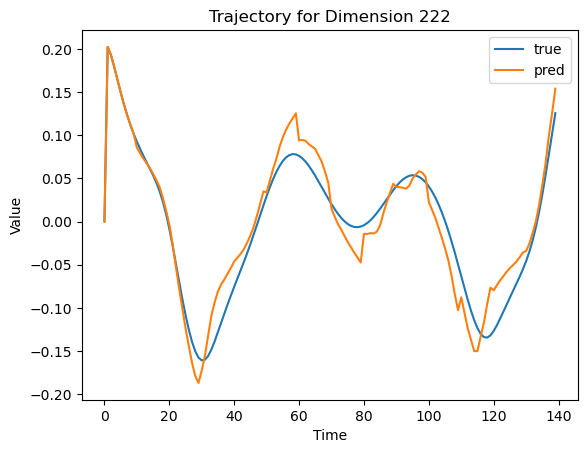

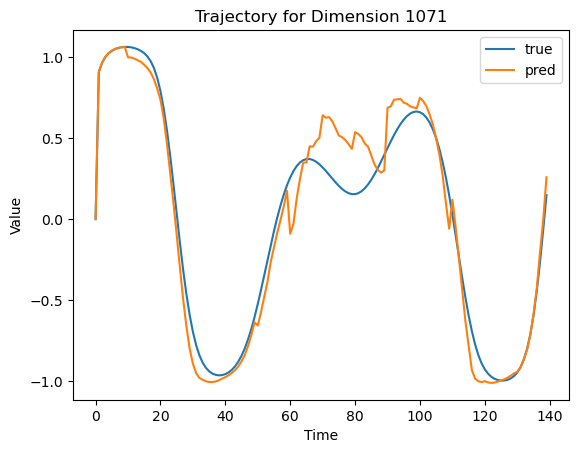

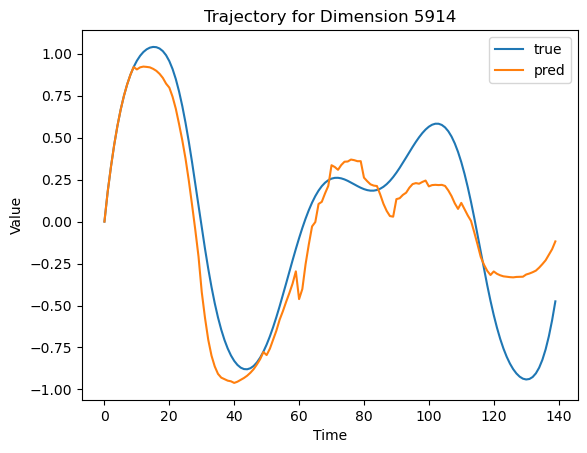

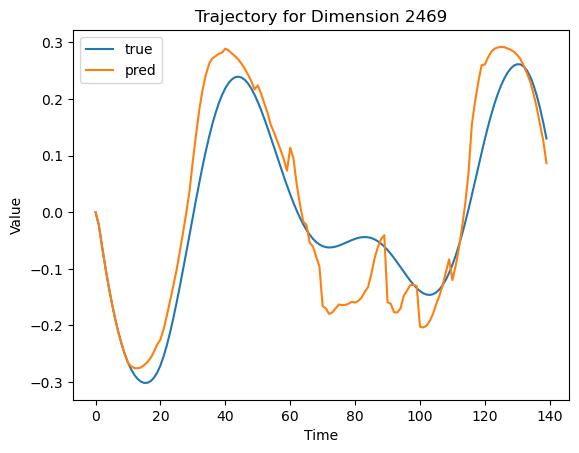

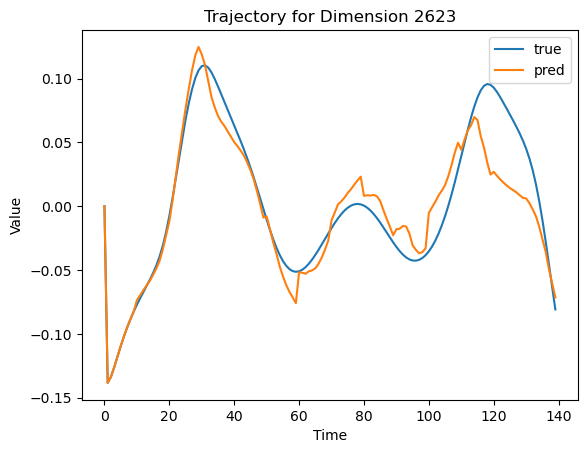

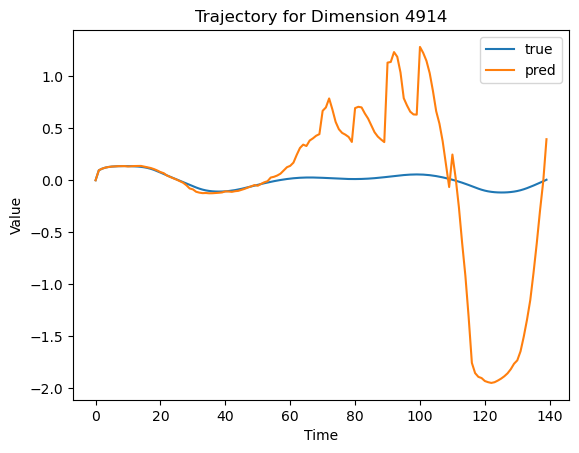

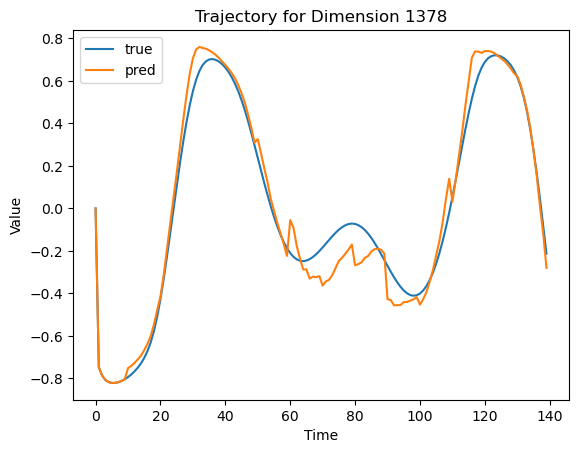

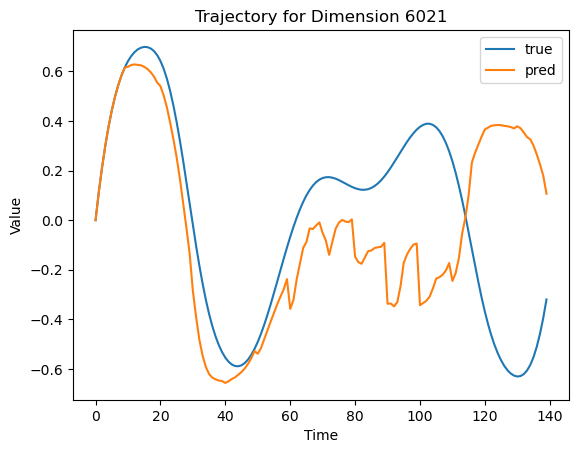

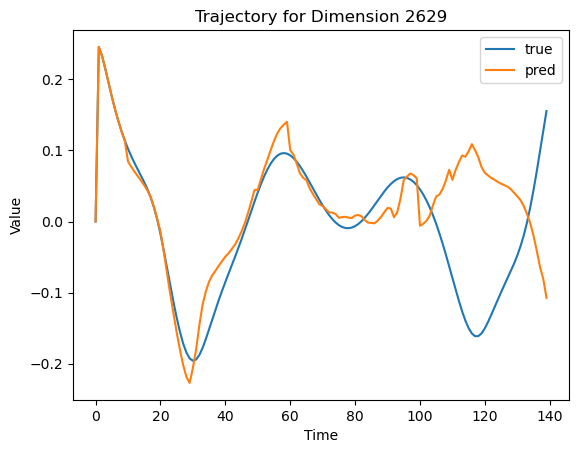

In [21]:
import numpy as np
import matplotlib.pyplot as plt

n_dimensions = x_dataset[1].shape[1]
selected_dimensions = np.random.choice(n_dimensions, 10, replace=False)
# selected_dimensions[-1] = 3229
# selected_dimensions = range(10)

for i in selected_dimensions:
    plt.figure()
    y_true = x_dataset[1]
    y_pred = y_data_pred_50traj_10predict[1]
    plt.plot(y_true[:, i], label = 'true')
    plt.plot(y_pred[:, i], label = 'pred')
    plt.title(f'Trajectory for Dimension {i}')
    plt.xlabel('Time')
    plt.ylabel('Value')
    plt.legend()
    plt.show()

In [22]:
errors = [y_data_pred_50traj_10predict[i] - x_dataset[i][:, :] for i in range(len(y_data_pred_50traj_10predict))]

ratios_all = np.zeros((len(errors), 6957))

for i in range(len(errors)):
    reference = x_dataset[i][:(steps * predict_num), :]
    error = errors[i]
    reference_norms = np.linalg.norm(reference, axis=0)
    error_norms = np.linalg.norm(error, axis=0)
    # print(error_norms)
    ratios_all[i] = error_norms / reference_norms

# 计算平均比值和标准差
mean_ratios = np.mean(ratios_all, axis=0)
std_ratios = np.std(ratios_all, axis=0)

mean_ratios, std_ratios

(array([0.36691081, 0.36692979, 0.36724528, ..., 0.58626753, 0.57171521,
        0.50788736]),
 array([0.27170729, 0.27170332, 0.271642  , ..., 0.23167974, 0.23349499,
        0.24386131]))

In [23]:
ratios_all[0]

array([0.29661023, 0.29664179, 0.29718963, ..., 0.63179101, 0.61373674,
       0.5382569 ])

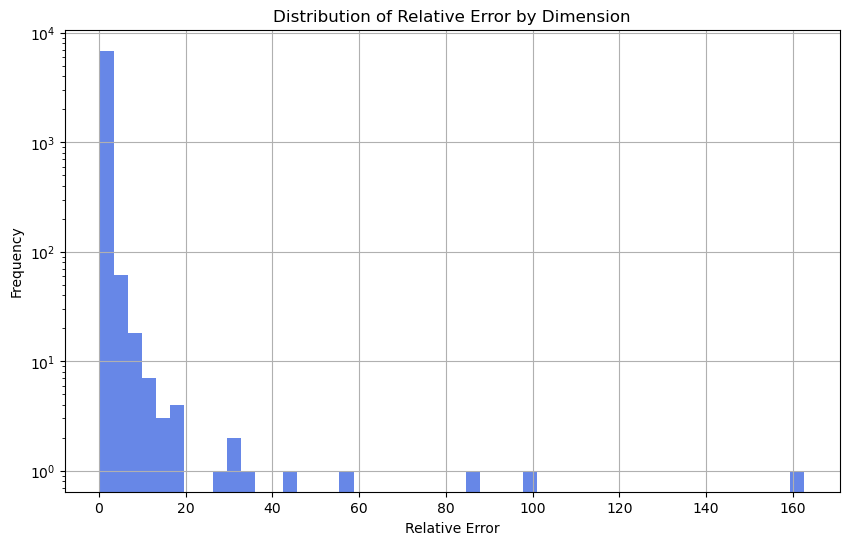

In [24]:
plt.figure(figsize=(10, 6))
plt.hist(mean_ratios, bins=50, alpha=0.8, color='royalblue')
plt.title('Distribution of Relative Error by Dimension')
plt.xlabel('Relative Error')
plt.ylabel('Frequency')
plt.yscale('log')
plt.grid(True)
plt.show()

In [25]:
max(mean_ratios)

162.63014670513616

In [26]:
mean_value = np.mean(mean_ratios)
print(mean_value)
count_above_mean = np.sum(mean_ratios > 0.2)
count_above_mean

0.7114702192601018


6957

In [27]:
indexes_large_error = np.where(mean_ratios > 0.1)
indexes_large_error_0 = np.where(ratios_all[0] > 0.1)
indexes_large_error

(array([   0,    1,    2, ..., 6954, 6955, 6956]),)

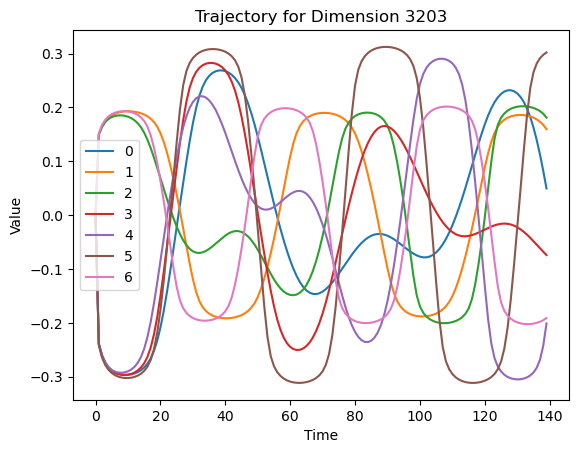

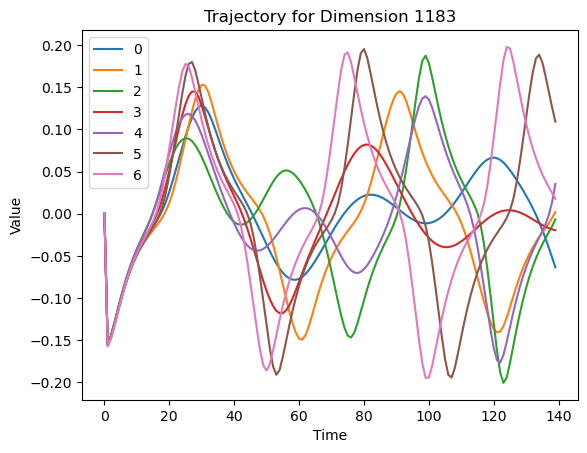

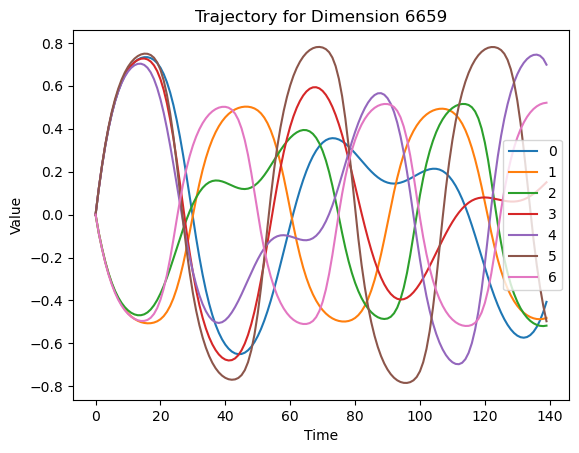

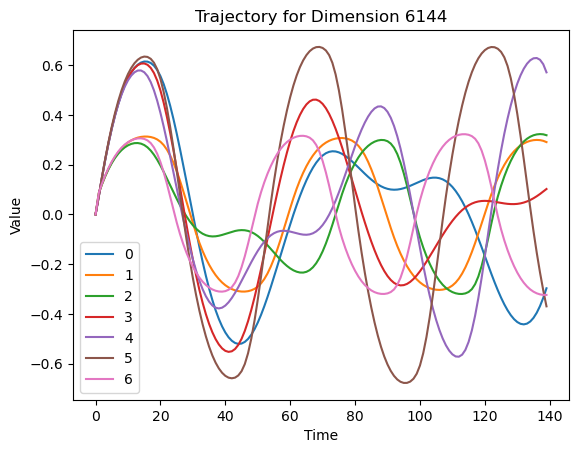

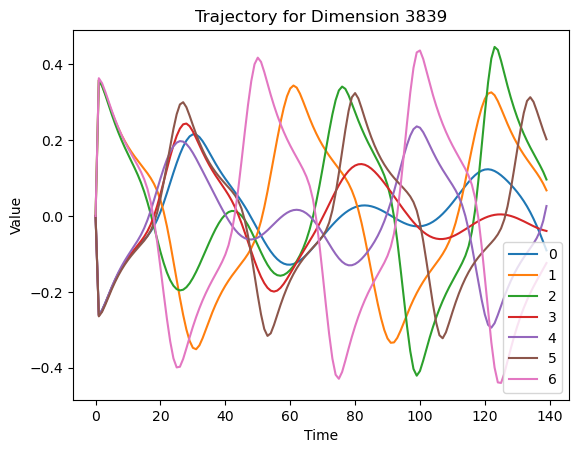

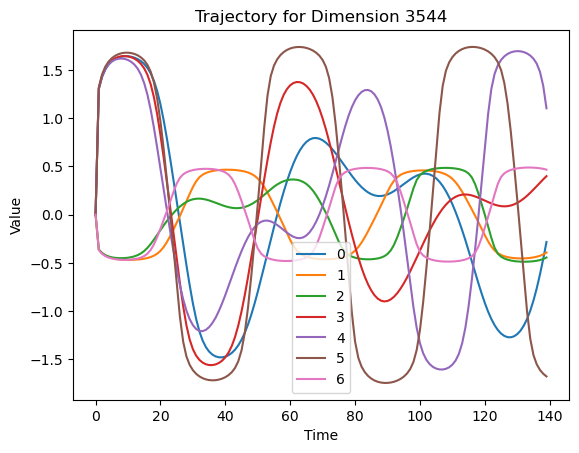

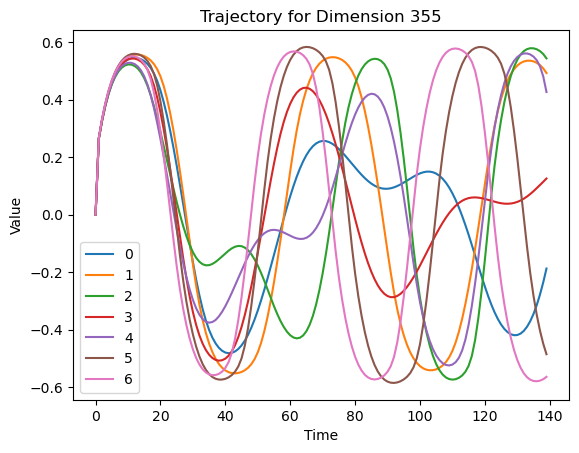

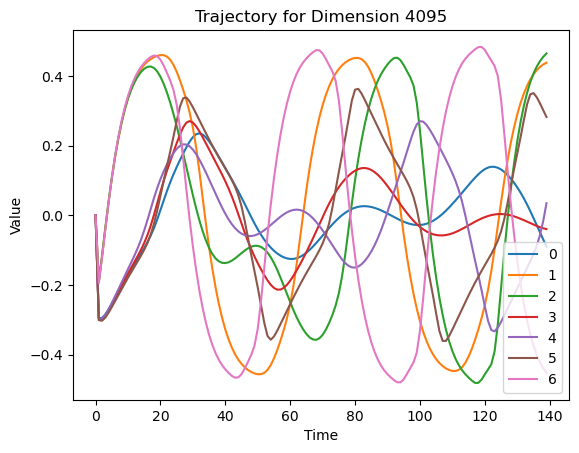

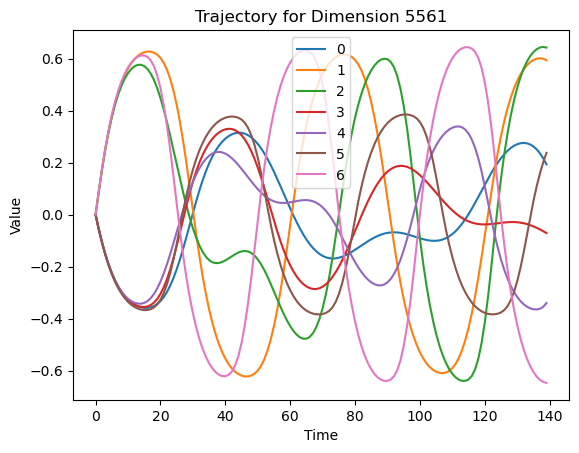

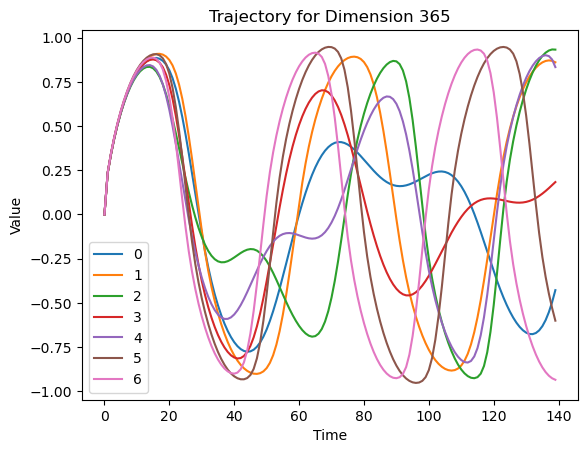

In [28]:
import numpy as np
import matplotlib.pyplot as plt

n_dimensions = x_dataset[0].shape[1]
selected_dimensions = np.random.choice(n_dimensions, 10, replace=False)
# selected_dimensions[-1] = 3229
# selected_dimensions = indexes_large_error[0]

for i in selected_dimensions:
    plt.figure()
    y_true = x_dataset[0]
    y_1 = x_dataset[5]
    y_2 = x_dataset[10]
    y_3 = x_dataset[15]
    y_4 = x_dataset[20]
    y_5 = x_dataset[25]
    y_6 = x_dataset[30]
    # y_pred = y_data_pred_50traj_10predict[0]
    plt.plot(y_true[:, i], label = '0')
    plt.plot(y_1[:, i], label = '1')
    plt.plot(y_2[:, i], label = '2')
    plt.plot(y_3[:, i], label = '3')
    plt.plot(y_4[:, i], label = '4')
    plt.plot(y_5[:, i], label = '5')
    plt.plot(y_6[:, i], label = '6')
    # plt.plot(y_pred[:, i], label = 'pred')
    plt.title(f'Trajectory for Dimension {i}')
    plt.xlabel('Time')
    plt.ylabel('Value')
    plt.legend()
    plt.show()

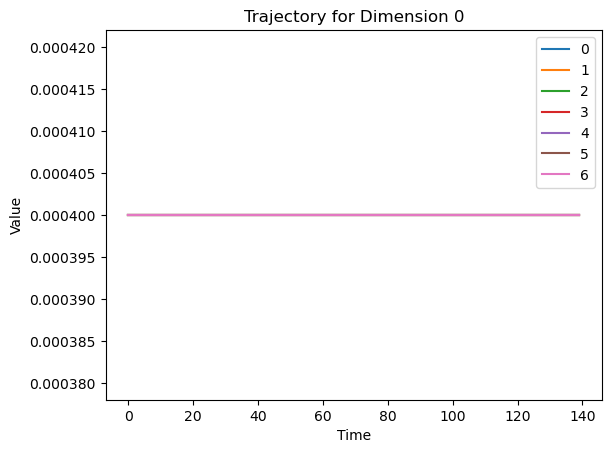

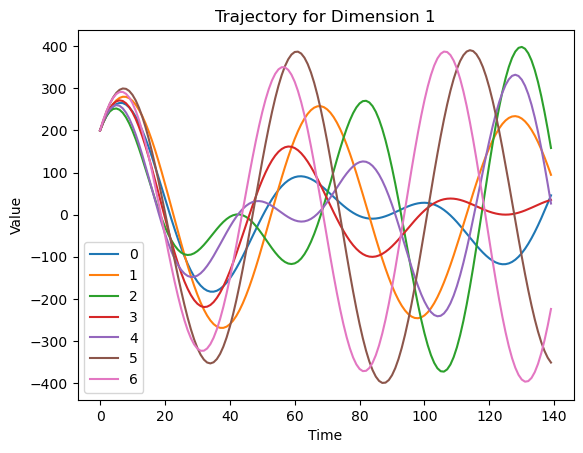

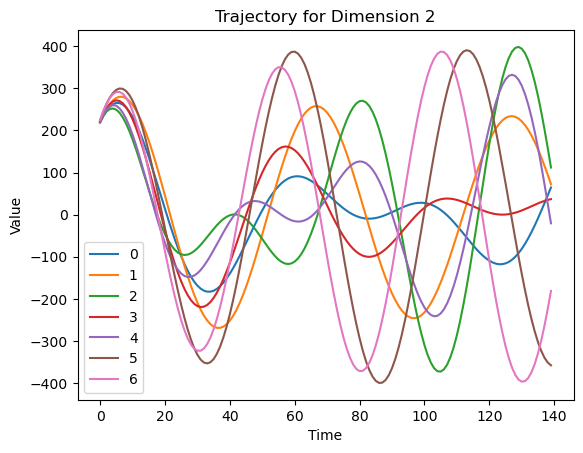

In [29]:
import numpy as np
import matplotlib.pyplot as plt

for i in range(3):
    plt.figure()
    u_0 = u1_dataset[0]
    u_1 = u1_dataset[5]
    u_2 = u1_dataset[10]
    u_3 = u1_dataset[15]
    u_4 = u1_dataset[20]
    u_5 = u1_dataset[25]
    u_6 = u1_dataset[30]
    plt.plot(u_0[:, i], label = '0')
    plt.plot(u_1[:, i], label = '1')
    plt.plot(u_2[:, i], label = '2')
    plt.plot(u_3[:, i], label = '3')
    plt.plot(u_4[:, i], label = '4')
    plt.plot(u_5[:, i], label = '5')
    plt.plot(u_6[:, i], label = '6')
    # plt.plot(y_pred[:, i], label = 'pred')
    plt.title(f'Trajectory for Dimension {i}')
    plt.xlabel('Time')
    plt.ylabel('Value')
    plt.legend()
    plt.show()